## Fashion-MNIST Classification Project

### Goal
The objective of this project is to build, train, evaluate, and persist a neural network model for clothing item classification using the Fashion-MNIST dataset. This includes:
- Designing a customizable Keras model with regularization 
- Training the model with early stopping and best model checkpointing 
- Evaluating performance on the test set 
- Saving and loading the model

### Dataset: Fashion-MNIST
Fashion-MNIST is a dataset designed as a drop-in replacement for MNIST, but with images of fashion products instead of handwritten digits. It contains 10 fashion categories labeled 0–9. 

#### Size:
- 60,000 training images 
- 10,000 test images 
- Each image: 28 × 28 pixels 
- Grayscale (1 channel)
- Flattened to a 784-dimensional vector for fully connected networks (28 × 28 = 784). 

#### Classes (label → name):
- 0 → T-shirt/top 
- 1 → Trouser 
- 2 → Pullover 
- 3 → Dress 
- 4 → Coat 
- 5 → Sandal 
- 6 → Shirt 
- 7 → Sneaker 
- 8 → Bag 
- 9 → Ankle boot 


In [2]:
import numpy as np
import tensorflow.keras as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import normalize

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print("x_train shape:", x_train.shape)  
print("y_train shape:", y_train.shape)  
print("x_test shape:", x_test.shape)    
print("y_test shape:", y_test.shape)   

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


### Visualize sample images 


Before building a model, it helps to visually inspect a small batch of images to confirm the dataset loaded correctly and to build intuition for what each label represents]  
The grid below shows 15 training examples (3 rows × 5 columns) with the class name as the titlplt.tight_layout()
plt.show()


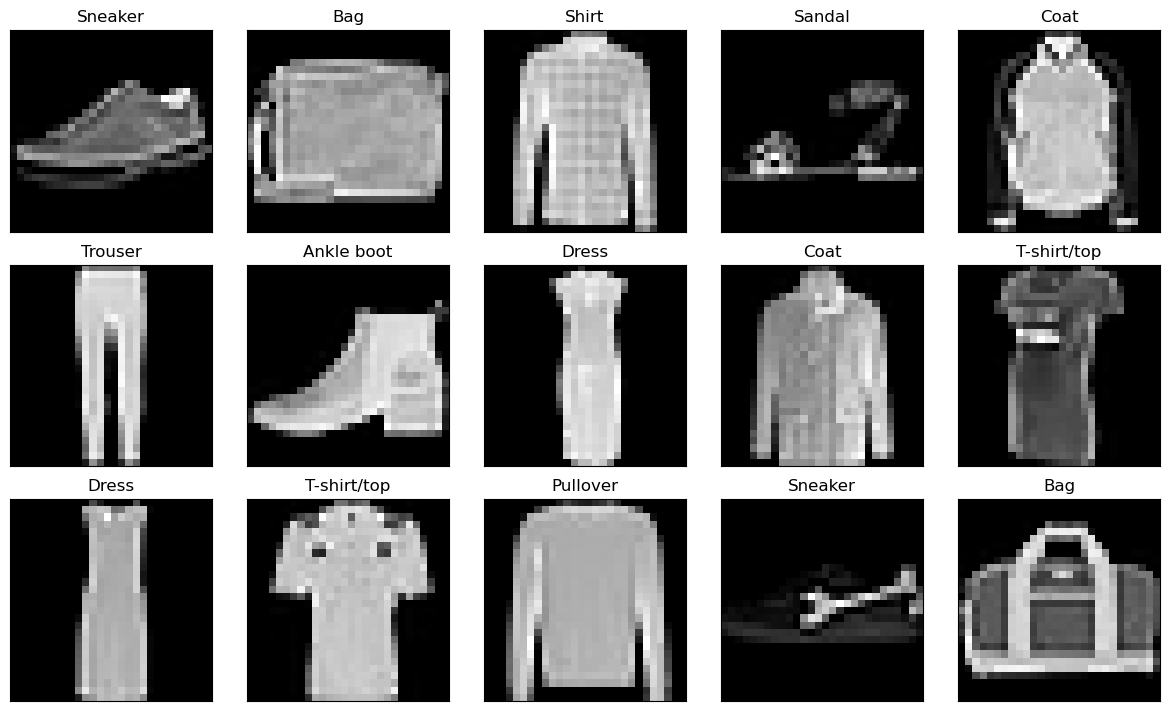

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Fashion-MNIST label names (0–9)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]  # label mapping used in the TensorFlow tutorial[1]

n_rows, n_cols = 3, 5
num_images = n_rows * n_cols

# Randomly pick 15 training samples (set a seed for reproducibility if desired)
indices = np.random.choice(len(x_train), size=num_images, replace=False)

plt.figure(figsize=(n_cols * 2.4, n_rows * 2.4))
for i, idx in enumerate(indices):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[idx], cmap="gray")
    plt.title(class_names[y_train[idx]])

plt.tight_layout()
plt.show()


### Normalize pixel values

Fashion-MNIST images are stored as grayscale integer pixel values in the range 0–255. 
Neural networks typically train more reliably when inputs are scaled to a small, consistent range, so the standard preprocessing step is to convert to floats and divide by 255 to map pixels to the range 0–1.
Apply the *same* normalization to both the training and test sets.


In [7]:
# Convert to float and normalize to[1]
x_train = x_train.astype("float32") / 255.0 
x_test  = x_test.astype("float32") / 255.0   

# Quick sanity check
print("x_train min/max:", x_train.min(), x_train.max())
print("x_test  min/max:", x_test.min(), x_test.max())

x_train min/max: 0.0 1.0
x_test  min/max: 0.0 1.0


### One-hot encode labels

Fashion-MNIST labels are integers from 0 to 9 (10 classes  
Many classification models (especially when using `categorical_crossentropy`) expect targets in one-hot encoded form, where each label becomes a length-`num_classes` binary vecto]  
The helper function below wraps `tf.keras.utils.to_categorical` so the notebook stays modular and the same encoding is applied consistently to both training and test labetest_oh shape:", y_test_oh.shape)


In [9]:
import tensorflow as tf

def one_hot(labels, classes=None):
    """
    Convert a 1D integer label vector into a one-hot encoded matrix.
    """
    return tf.keras.utils.to_categorical(labels, num_classes=classes)  


# Call the function for Fashion-MNIST (10 classes)
y_train_oh = one_hot(y_train, classes=10) 
y_test_oh  = one_hot(y_test, classes=10) 

print("y_train_oh shape:", y_train_oh.shape)
print("y_test_oh shape:", y_test_oh.shape)

y_train_oh shape: (60000, 10)
y_test_oh shape: (10000, 10)


### Build the model 

This step defines a reusable `build_model(...)` function that creates a fully-connected network using the Keras Functional API (`keras.Input` → layers → `keras.Model`). 
Each Dense layer applies L2 weight regularization via `kernel_regularizer=tf.keras.regularizers.L2(lambtha)` to help reduce overfitting. 
Dropout is applied between hidden layers using a *drop rate* of `1 - keep_prob` (Keras `Dropout(rate=...)` drops a fraction `rate` of units during training).

In [2]:
import tensorflow as tf
import tensorflow.keras as K

def build_model(nx, layers, activations, lambtha, keep_prob):
    """
    Builds a neural network using the Keras Functional API.
    """
    inputs = K.Input(shape=(nx,))

    x = inputs
    for i in range(len(layers)):
        x = K.layers.Dense(layers[i], activation=activations[i], kernel_regularizer=K.regularizers.L2(lambtha)
        )(x)

        # Dropout on hidden layers only
        if i != len(layers) - 1 and keep_prob is not None:
            x = K.layers.Dropout(rate=1 - keep_prob)(x)

    model = K.Model(inputs, x)
    return model


# Example call (for flattened Fashion-MNIST: nx = 28*28 = 784)
nx = 28 * 28

model = build_model(
    nx=nx,
    layers=[256, 128, 10],
    activations=["relu", "relu", "softmax"],
    lambtha=1e-4,
    keep_prob=0.8
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

### Compile (optimize) the model

This step wraps model compilation into an `optimize_model(...)` function so optimizer settings are configured in one place and can be reused across experiments  
The function uses the Adam optimizer, which accepts `learning_rate`, `beta_1`, and `beta_2` as key hyperparameter5]  
Because labels were one-hot encoded earlier, the model is compiled with `categorical_crossentropy` and accuracy as a met    )  # Adam hyperparamete
 performance.

In [13]:
import tensorflow.keras as K

def optimize_model(network, alpha, beta1, beta2):
    """
    Configures (compiles) a Keras model for multi-class classification using Adam.
    """
    adam_optimizer = K.optimizers.Adam(
        learning_rate=alpha,
        beta_1=beta1,
        beta_2=beta2
    )

    # This is the missing step: compile the model before calling fit() [web:172]
    network.compile(
        optimizer=adam_optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )  # compile configures optimizer/loss/metrics for training [web:181]

# Call it (then you can train)
optimize_model(model, alpha=0.001, beta1=0.9, beta2=0.999)


### Train the model (with callbacks)

This step encapsulates training into a `train_model(...)` function and optionally adds callbacks for early stopping, learning-rate scheduling, and saving the best model checkpoint. 
`EarlyStopping(monitor="val_loss", patience=...)` stops training when the validation loss stops improving. 
`LearningRateScheduler` updates the optimizer learning rate at the start of each epoch using a user-provided schedule function that receives the epoch index and current learning rate.

In [15]:
def train_model(network, data, labels, batch_size,
                epochs, validation_data=None, early_stopping=False,
                patience=0, learning_rate_decay=False, alpha=0.1,
                decay_rate=1, save_best=False, filepath=None,
                verbose=True, shuffle=False):
    """
    Trains a model using mini-batch gradient descent, with optional callbacks.
    """
    callbacks = []

    # Early stopping (requires validation data)
    if early_stopping and validation_data is not None:
        early_stop = K.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience
        )  #
        callbacks.append(early_stop)

    # Inverse time learning-rate decay (requires validation data)
    if learning_rate_decay and validation_data is not None:
        # Keras passes (epoch, current_lr) to the schedule function
        def scheduler(epoch, lr):
            return alpha / (1 + decay_rate * epoch)

        inv_time_decay = K.callbacks.LearningRateScheduler(
            scheduler,
            verbose=1
        )  
        callbacks.append(inv_time_decay)

    # Save best model (requires a filepath)
    if save_best:
        if filepath is None:
            raise ValueError("filepath must be provided when save_best=True")

        save_best_model = K.callbacks.ModelCheckpoint(
            filepath=filepath,
            monitor="val_loss",
            save_best_only=True
        )  
        callbacks.append(save_best_model)

    history = network.fit(
        x=data,
        y=labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        callbacks=callbacks,   
        verbose=verbose,
        shuffle=shuffle
    )

    return history



In [16]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat  = x_test.reshape(x_test.shape[0], -1)

history = train_model(
    network=model,
    data=x_train_flat,
    labels=y_train_oh,
    batch_size=128,
    epochs=20,
    validation_data=(x_test_flat, y_test_oh),
    early_stopping=True,
    patience=3,
    learning_rate_decay=True,
    alpha=1e-3,
    decay_rate=1,
    save_best=True,
    filepath="best_fashion_mnist_model.keras",
    verbose=1,
    shuffle=True
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7242 - loss: 0.8416 - val_accuracy: 0.8343 - val_loss: 0.5115 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8550 - loss: 0.4609 - val_accuracy: 0.8565 - val_loss: 0.4492 - learning_rate: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0003333333333333333.
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8675 - loss: 0.4236 - val_accuracy: 0.8648 - val_loss: 0.4320 - learning_rate: 3.3333e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00025.
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8765 - loss: 0.3951 - val_accuracy: 0.8701 - val_loss: 0.4103 - learning_rate: 2.5000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0002.
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━

### Plot training curves (loss & accuracy)

After training, the returned `History` object stores per-epoch metrics in `history.history` (e.g., `loss`, `accuracy`, and—if validation data was provided—`val_loss`, `val_accuracy`). 
Plotting loss and accuracy side-by-side helps quickly spot overfitting (training improves while validation degrades) and whether training has converged.

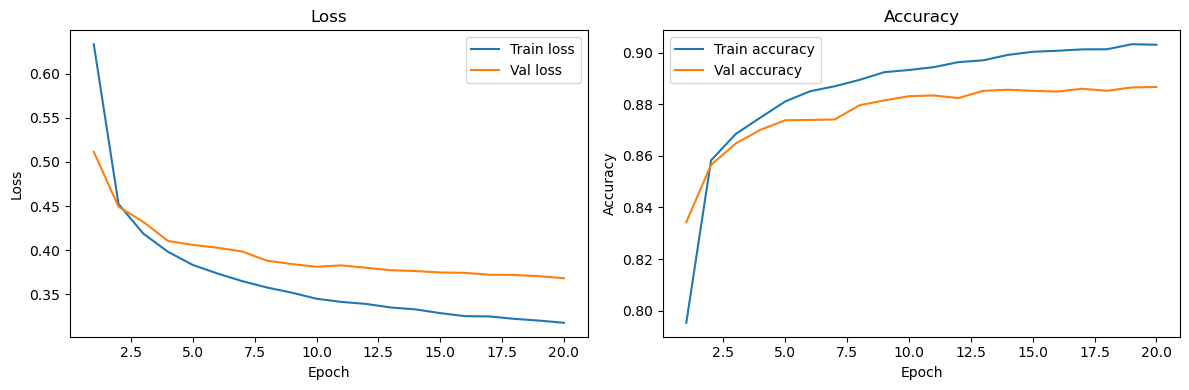

In [28]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = history.history  # dict of tracked metrics per epoch[1]
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # ---- Loss ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["loss"], label="Train loss")
    if "val_loss" in hist:
        plt.plot(epochs, hist["val_loss"], label="Val loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # ---- Accuracy ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist.get("accuracy", []), label="Train accuracy")
    if "val_accuracy" in hist:
        plt.plot(epochs, hist["val_accuracy"], label="Val accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call after training
plot_history(history)

### Evaluate on the test set (accuracy + confusion matrix)

After training, evaluate the model on unseen test data using `model.evaluate(...)`, which returns the loss value and any compiled metrics (e.g., accuracy).  
To inspect *where* the model makes mistakes across the 10 classes, compute a confusion matrix; its rows represent true labels and columns represent predicted labels, producing an \(n \times n\) matrix for \(n\) classes. 


In [31]:
import numpy as np
import tensorflow as tf

# If you trained a Dense-only model on flattened inputs, use x_test_flat.
# Otherwise, replace x_test_flat with x_test (and ensure it matches the model input shape).
x_eval = x_test_flat if "x_test_flat" in globals() else x_test

# --- Test loss & accuracy ---
test_loss, test_acc = model.evaluate(x_eval, y_test_oh, verbose=0)  # returns loss + metrics[1]
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# --- Confusion matrix ("accuracy matrix") ---
y_pred_proba = model.predict(x_eval, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_oh, axis=1)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=10).numpy()  # rows=true, cols=pred[2]
print("Confusion matrix (counts):")
print(cm)

# Optional: normalized confusion matrix (row-wise)
cm_norm = cm / cm.sum(axis=1, keepdims=True)
print("\nConfusion matrix (row-normalized):")
print(np.round(cm_norm, 3))


Test loss: 0.3680
Test accuracy: 0.8867
Confusion matrix (counts):
[[840   2  15  27   6   0 102   0   8   0]
 [  3 966   1  22   4   0   3   0   1   0]
 [ 12   0 809  14 105   0  59   0   1   0]
 [ 21   8  11 902  34   0  22   0   2   0]
 [  0   1  91  32 830   0  45   0   1   0]
 [  0   0   0   1   0 969   0  18   1  11]
 [123   1  88  30  80   0 664   0  14   0]
 [  0   0   0   0   0  19   0 958   1  22]
 [  4   1   4   3   6   2   3   3 974   0]
 [  0   0   0   0   0   5   1  39   0 955]]

Confusion matrix (row-normalized):
[[0.84  0.002 0.015 0.027 0.006 0.    0.102 0.    0.008 0.   ]
 [0.003 0.966 0.001 0.022 0.004 0.    0.003 0.    0.001 0.   ]
 [0.012 0.    0.809 0.014 0.105 0.    0.059 0.    0.001 0.   ]
 [0.021 0.008 0.011 0.902 0.034 0.    0.022 0.    0.002 0.   ]
 [0.    0.001 0.091 0.032 0.83  0.    0.045 0.    0.001 0.   ]
 [0.    0.    0.    0.001 0.    0.969 0.    0.018 0.001 0.011]
 [0.123 0.001 0.088 0.03  0.08  0.    0.664 0.    0.014 0.   ]
 [0.    0.    0.    0.   

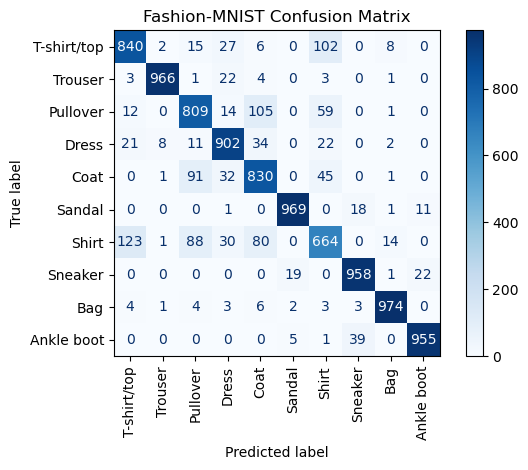

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = list(range(10))
display_labels = class_names if "class_names" in globals() else labels

disp = ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    labels=labels,
    display_labels=display_labels,
    cmap="Blues",
    xticks_rotation="vertical"
)  

disp.ax_.set_title("Fashion-MNIST Confusion Matrix")
plt.tight_layout()
plt.show()
